# Colorization Network

## Imports

In [35]:
import os
import math
import random

import cv2

import PIL

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.color import lab2rgb, rgb2lab
from skimage import io

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

## Get image data

In [21]:
data_set_dir = './DataSet'
image_paths = os.listdir(data_set_dir)
image_paths = [image_path for image_path in image_paths if image_path.endswith('.jpg')]
random.shuffle(image_paths)
image_data = [cv2.imread(os.path.join(data_set_dir, image_path)) for image_path in image_paths]

## Some Preprocessing

In [22]:
# LAB color space
image_data = [cv2.cvtColor(image, cv2.COLOR_BGR2LAB) for image in image_data]

In [23]:
# Normalize images
transform_color = transforms.Compose([transforms.ToTensor()])

transformed_image_data = []
for i, image in enumerate(image_data):
    image_lab = transform_color(image)
    image_gray = image_lab[0:1,:,:]
    image_ab = transform_color(image)[1:,:,:]
    transformed_image_data.append((image_gray, image_lab, image_ab))

## Train/Test Split

In [24]:
batch_size = 4
test_size = 0.8
index_test = math.floor(len(image_data) * test_size)

# include both color and gray images
trainloader = torch.utils.data.DataLoader(transformed_image_data[:index_test], batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(transformed_image_data[index_test:], batch_size=batch_size,
                                         shuffle=False, num_workers=0)

## Plot some images

In [25]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = npimg.astype('float64')
    plt.imshow(npimg)
    plt.show()

In [26]:
# get some random training images
dataiter = iter(trainloader)
images_gray, images_color, images_ab = dataiter.next()

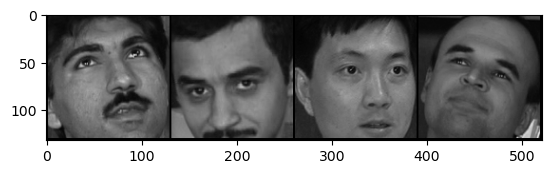

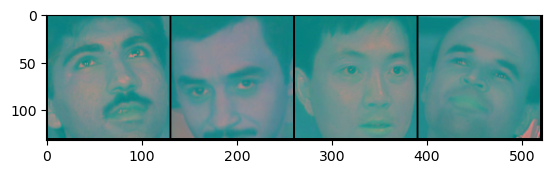

In [28]:
# show some images
imshow(torchvision.utils.make_grid(images_gray))
imshow(torchvision.utils.make_grid(images_color))

## Define network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.downsample = nn.Sequential(
            nn.Conv2d(1, 8, 3, 2, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 2, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 8, 2, 2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 2, 2, 2)
        )

    def forward(self, x):
        midlevel = self.downsample(x)
        output = self.upsample(midlevel)
        return output

net = Net()

### Move to cuda if possible

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
print(device)

cuda:0


## Define optimizer

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=0.0)

## Train

In [12]:
num_mini_batch_print = 50

for epoch in range(10):  # loop over the dataset multiple times
    print(f'----epoch: {epoch}')
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_gray, images_color, images_ab = data[0].to(device), data[1].to(device), data[2].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images_gray)
        loss = criterion(outputs, images_ab)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % num_mini_batch_print == num_mini_batch_print - 1:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_mini_batch_print))
            running_loss = 0.0

print('Finished Training')

----epoch: 0
[1,    50] loss: 0.030
[1,   100] loss: 0.001
[1,   150] loss: 0.001
----epoch: 1
[2,    50] loss: 0.001
[2,   100] loss: 0.001
[2,   150] loss: 0.001
----epoch: 2
[3,    50] loss: 0.001
[3,   100] loss: 0.001
[3,   150] loss: 0.000
----epoch: 3
[4,    50] loss: 0.001
[4,   100] loss: 0.001
[4,   150] loss: 0.000
----epoch: 4
[5,    50] loss: 0.000
[5,   100] loss: 0.000
[5,   150] loss: 0.000
----epoch: 5
[6,    50] loss: 0.000
[6,   100] loss: 0.000
[6,   150] loss: 0.000
----epoch: 6
[7,    50] loss: 0.000
[7,   100] loss: 0.000
[7,   150] loss: 0.000
----epoch: 7
[8,    50] loss: 0.000
[8,   100] loss: 0.000
[8,   150] loss: 0.000
----epoch: 8
[9,    50] loss: 0.000
[9,   100] loss: 0.000
[9,   150] loss: 0.000
----epoch: 9
[10,    50] loss: 0.000
[10,   100] loss: 0.000
[10,   150] loss: 0.000
Finished Training


## Save Model

In [13]:
PATH = './colorize_net.pth'
torch.save(net.state_dict(), PATH)

## Evaluate Model
### Peak at 4 test examples

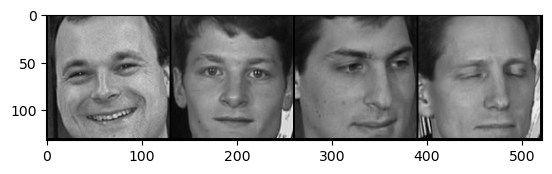

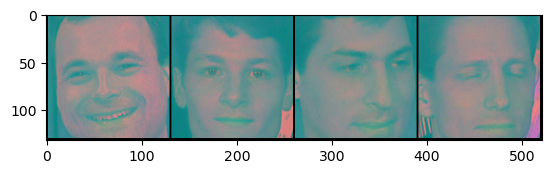

In [14]:
dataiter = iter(testloader)
images_gray, images_color, images_ab = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images_gray))
imshow(torchvision.utils.make_grid(images_color))

### Look at model performance on these examples

In [15]:
outputs = net(images_gray.to(device)).cpu()

### Combine l, a and b channels

In [16]:
outputs = torch.cat((images_gray, outputs), 1)

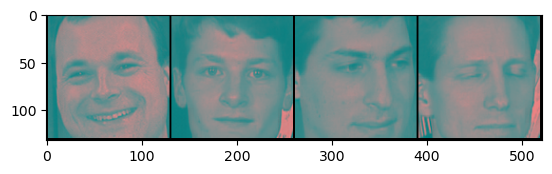

In [17]:
imshow(torchvision.utils.make_grid(outputs))

# TODO - Convert output LAB image to RGB (

### To RGB

In [36]:
images_RGB = []

for output in outputs:
    rgb = io.imread(output)
    lab = color.rgb2lab(rgb)
    x = torch.from_numpy(lab)
    plt.imshow(x)
    plt.show()
#     img = output.detach().numpy()
#     #convert image back to Height,Width,Channels
#     img = np.transpose(img, (1,2,0))
#     img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
#     #show the image
#     plt.imshow(img)
#     plt.show()
#     output = torch.permute(output, (1, 2, 0))
#     image_RGB = cv2.cvtColor(output.numpy(), cv2.COLOR_LAB2RGB)
#     image_RGB = torch.tensor(image_RGB)
#     image_RGB = torch.permute(image_RGB, (2, 0, 1))
#     images_RGB.append(image_RGB.numpy())

images_RGB = torch.tensor(np.array(images_RGB))

OSError: Cannot understand given URI: tensor([[[0.2118, 0.1882, 0.0902,  ..., 0.1333, 0.1294, 0....

In [ ]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = npimg.astype('float64')
    plt.imshow(npimg)
    plt.show()

In [ ]:
imshow(torchvision.utils.make_grid(images_RGB))